In [1]:
import sys, os, pickle
import torch
sys.path.append('/home/om2382/mft-theory/')
from cluster import *
from core import *
from empirics import *
from functions import *
from ode_methods import *
from plotting import *
from theory import *
from utils import *
from functools import partial
import matplotlib.pyplot as plt

In [ ]:
### To do
#memory issue to get more data points and larger networks in estimating psi
#turn psi estimation into function suite for different cases
#find relevant range of connectivity parameter values to simluate

In [2]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 10
macro_configs = config_generator(g=[3, 8, 20],
                                 alpha=[0.5, 0.75, 1, 10],
                                 PR_G=[0.5, 0.75, 1])

micro_configs = tuple(product(macro_configs, list(range(n_seeds))))
prototype = False

### --- SELECT PARTICULAR CONFIG --- ###
try:
    i_job = int(os.environ['SLURM_ARRAY_TASK_ID']) - 1
except KeyError:
    i_job = 0
    prototype = True
params, i_seed = micro_configs[i_job]
i_config = i_job//n_seeds

new_random_seed_per_condition = True
if new_random_seed_per_condition:
    np.random.seed(i_job)
else: #Match random seeds across conditions
    np.random.seed(i_seed)

In [3]:
### --- Set parameters --- ###
N = 4000
g = params['g']
T_window = 100
dT = 0.05
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
lags = np.arange(0, T_window, dT)
n_lags = int(T_window/dT)
lags_full = np.concatenate([-lags[-n_lags:][::-1], lags[1:n_lags], np.array([lags[-1]])])

In [6]:
### --- Estimate psi empirically --- ###

#Set empirical parameters

dT_emp = 0.5
lags_emp = np.arange(0, T_window, dT_emp)
n_lags_emp = int(T_window/dT_emp)


#Generate LDRG matrix

alpha = params['alpha']
K = int(alpha * N)
rho = np.zeros(K)
gamma = 1
H = int(gamma * K)
rho[:H] = 0
X1 = np.random.normal(0, 1, (N, K))
X2 = np.random.normal(0, 1, (N, K))
Y = np.random.normal(0, 1, (N, K))
L = np.sqrt((1 - rho)/N)*X1 + np.sqrt(rho/N)*Y
RT = (np.sqrt((1 - rho)/N)*X2 + np.sqrt(rho/N)*Y).T
#L = np.random.normal(0, 1/np.sqrt(N), (N, K))
#RT = np.random.normal(0, 1/np.sqrt(N), (K, N))

g_eff = g
D = np.ones(K)
beta = get_exact_beta_for_PR(params['PR_G'])[1]
G = np.exp(-beta*np.arange(N)/N)
g_correction = g_eff / np.sqrt(np.sum(D**2)/N*np.sum(G**2)/N)

W = np.einsum('ik, k, kj, j -> ij', L, D, RT, G) * g_correction
del L
del RT

#compute psi
W_ = torch.from_numpy(W).type(torch.FloatTensor).to(0)
Psi = estimate_psi(lags_emp, T_sim=2000, dt_save=dT_emp, dt=0.05,
                   W=W_, phi_torch=phi_torch, T_save_delay=1000, N_batch=1, N_loops=100)

#symmetrize psi for comparison
Psi = Psi.cpu().detach().numpy()
Psi_emp = np.concatenate([Psi[-n_lags_emp:][::-1], Psi[1:n_lags_emp]])
lags_emp_full = np.concatenate([-lags_emp[-n_lags_emp:][::-1], lags_emp[1:n_lags_emp]])

In [ ]:
### -- Optional: measure single-unit properties empirically --- ###
if False:
    phi_prime = lambda x: torch.exp(-(np.pi/4)*x**2)
    generate_W = lambda g, N: g*np.random.normal(0, 1/np.sqrt(N), (N, N))
    
    C_Phi_half_emp, alpha_emp = estimate_single_unit_autocov_and_alpha(lags, T_sim=3000, dt_save=dT, dt=0.05,
                                                                       generate_W=partial(generate_W, g=g, N=N),
                                                                       N=N, phi_torch=phi_torch, phi_prime=phi_prime_torch,
                                                                       T_save_delay=100,
                                                                       N_batch=2, N_disorder=2)
if False:
    alpha = alpha_emp
    C_Phi_half = C_Phi_half_emp.cpu().detach().numpy()

In [7]:
### --- Compute single-unit properties

d = compute_Delta_0(g=g)
time, Delta_T = integrate_potential(d, g=g, tau_max=T_window, N_tau=int(T_window/dT))
Delta_T = fix(Delta_T)
C_Phi_half = compute_C_simple(d, Delta_T)
alpha = compute_phi_prime_avg(d)

In [8]:
### --- Compute Psi from theory --- ###

#Define relevant single-unit functions
C_phi = np.concatenate([C_Phi_half[-n_lags:][::-1],
                        C_Phi_half[1:n_lags],
                        np.array([C_Phi_half[-1]])])
C_phi_omega = fft(C_phi, dT)
T = len(C_phi)
t_indices= np.concatenate([np.arange(0, T//2), np.arange(-T//2, 0)])
sampfreq = 1/dT
w = 2*np.pi*sampfreq*t_indices/T
C_phi_C_phi = np.multiply.outer(C_phi_omega, C_phi_omega)
S_phi = alpha/(np.sqrt(2*np.pi)*(1 + 1j*w))
S_phi_S_phi = np.multiply.outer(S_phi, S_phi)

#Compute psi for LDRG network

PR_G = (np.sum(G**2))**2/np.sum(G**4)/N
PR_D = (np.sum(D**2))**2/np.sum(D**4)/N
num = 1 + (1/PR_D + 1/PR_G - 1)*np.abs(2*np.pi*g**2 * S_phi_S_phi)**2
denom = np.abs(1 - 2*np.pi*g**2 * S_phi_S_phi)**2
Psi_omega1_omega2 = (num / denom - 1) * C_phi_C_phi
Psi_tau1_tau2 = ifft(Psi_omega1_omega2, dT)
Psi_tau_tau = np.diag(Psi_tau1_tau2)
Psi_tau_tau_ds = Psi_tau_tau[::int(dT_emp/dT)][:-1]

In [10]:
C2 = C_Phi_half[0]**2
dim_emp = C2/(C2 + np.amax(np.abs(Psi_emp)))
dim_theory = C2/(C2 + np.amax(np.abs(Psi_tau_tau)))

0.015518507220410125
0.013521170720281833


In [ ]:
#processed_data = np.array([lags_emp_full, Psi_emp, Psi_tau_tau_ds])
processed_data = np.array([dim_emp, dim_theory])
#processed_data = np.array([lags_emp_full, Psi_tau_tau_ds])

In [ ]:
#plt.plot(lags_emp_full, Psi_emp)
#plt.plot(lags_emp_full, Psi_tau_tau_ds)

In [ ]:
### --- SAVE RESULTS -- ###
result = {'sim': None, 'i_seed': i_seed, 'config': params,
          'i_config': i_config, 'i_job': i_job}
try:
    result['processed_data'] = processed_data
except NameError:
    pass
    
try:
    save_dir = os.environ['SAVEDIR']
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_path = os.path.join(save_dir, 'result_{}'.format(i_job))

    with open(save_path, 'wb') as f:
        pickle.dump(result, f)
except KeyError:
    pass

In [18]:
###Truncate file above
file_name = 'LDRG_theory_match'
job_name = 'LDRG_PR_match'
project_dir = '/home/om2382/low-rank-dims/'
main_script_path = os.path.join(project_dir, 'cluster_main_scripts', job_name + '.py')
get_ipython().run_cell_magic('javascript', '', 'IPython.notebook.save_notebook()')
get_ipython().system('jupyter nbconvert --to script --no-prompt {}.ipynb'.format(file_name))
get_ipython().system('awk "/###Truncate/ {{exit}} {{print}}" {}.py'.format(file_name))
get_ipython().system('sed -i "/###Truncate/Q" {}.py'.format(file_name))
get_ipython().system('mv {}.py {}'.format(file_name, main_script_path))

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook LDRG_theory_match.ipynb to script
[NbConvertApp] Writing 12094 bytes to LDRG_theory_match.py
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2b200b651d50> <built-in function print>
awk: cmd. line:1:                       ^ syntax error
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2b200b651d50> <built-in function print>
awk: cmd. line:1:                                                                                ^ syntax error


In [19]:
###Submit job to cluster
n_jobs = len(micro_configs)
write_job_file(job_name, py_file_name='{}.py'.format(job_name), mem=64, n_hours=1, n_gpus=1)
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
submit_job(job_script_path, n_jobs, execute=False)

rm: cannot remove ‘/home/om2382/low-rank-dims/results/misc/LDRG_PR_match/result_*’: No such file or directory
sending incremental file list
mft-theory/
mft-theory/.DS_Store
mft-theory/.gitignore
mft-theory/README.md
mft-theory/__init__.py
mft-theory/jupyter_notebook.py
mft-theory/main.ipynb
mft-theory/.idea/
mft-theory/.idea/mft-theory.iml
mft-theory/.idea/misc.xml
mft-theory/.idea/modules.xml
mft-theory/.idea/vanilla-rtrl.iml
mft-theory/.idea/vcs.xml
mft-theory/.idea/workspace.xml
mft-theory/.idea/codeStyles/
mft-theory/.idea/codeStyles/codeStyleConfig.xml
mft-theory/.ipynb_checkpoints/
mft-theory/.ipynb_checkpoints/main-checkpoint.ipynb
mft-theory/LDR_dim/
mft-theory/LDR_dim/__init__.py
mft-theory/LDR_dim/solve_ldr.ipynb
mft-theory/LDR_dim/util.py
mft-theory/LDR_dim/LDR-dim/
mft-theory/LDR_dim/LDR-dim/__init__.py
mft-theory/LDR_dim/LDR-dim/solve_ldr.ipynb
mft-theory/LDR_dim/LDR-dim/util.py
mft-theory/cluster/
mft-theory/cluster/__init__.py
mft-theory/cluster/close_jupyter_notebook.py

In [23]:
###Get job status
get_ipython().system('squeue -u om2382')

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
  3333177_[21-360]    lkumar LDRG_PR_   om2382 PD       0:00      1 (Resources)
           3331144    lkumar  jupyter   om2382  R    1:48:52      1 ax14
         3333177_1    lkumar LDRG_PR_   om2382  R       8:56      1 ax14
         3333177_2    lkumar LDRG_PR_   om2382  R       8:56      1 ax14
         3333177_3    lkumar LDRG_PR_   om2382  R       8:56      1 ax14
         3333177_4    lkumar LDRG_PR_   om2382  R       8:56      1 ax14
         3333177_5    lkumar LDRG_PR_   om2382  R       8:56      1 ax14
         3333177_6    lkumar LDRG_PR_   om2382  R       8:56      1 ax14
         3333177_7    lkumar LDRG_PR_   om2382  R       8:56      1 ax15
         3333177_8    lkumar LDRG_PR_   om2382  R       8:56      1 ax15
         3333177_9    lkumar LDRG_PR_   om2382  R       8:56      1 ax15
        3333177_10    lkumar LDRG_PR_   om2382  R       8:56      1 ax15
        3333177_11    lkumar LDR

In [2]:
project_dir = '/home/om2382/low-rank-dims/'
job_name = 'LDRG_PR_match'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
configs_array, results_array, key_order, sim_dict = unpack_processed_data(job_script_path)

In [ ]:
job_name = 'LDRG_fit_correction_2'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
configs_array_1, results_array_1, key_order_1, sim_dict_1 = unpack_processed_data(job_script_path)

In [ ]:
!ls -t ../job_scripts/

In [3]:
results_array.shape

(3, 4, 3, 10, 2)

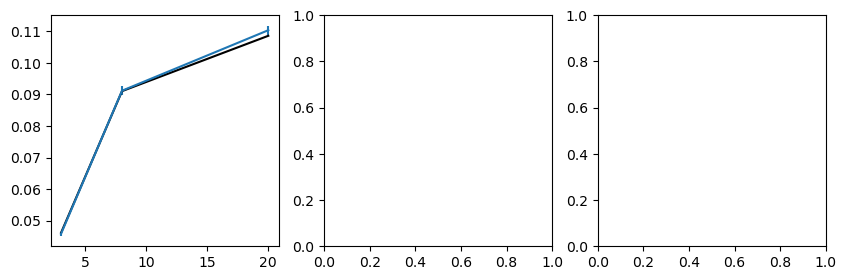

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
#g_eff plot
mean_pr = results_array[:,-1,-1,:,0].mean(-1)
sem_pr = results_array[:,-1,-1,:,0].std(-1)/np.sqrt(10)
ax[0].errorbar(configs_array['g'], mean_pr, yerr=sem_pr, color='C0')
ax[0].plot(configs_array['g'], results_array[:,-1,-1,0,1], color='k')

(0.0, 0.15)

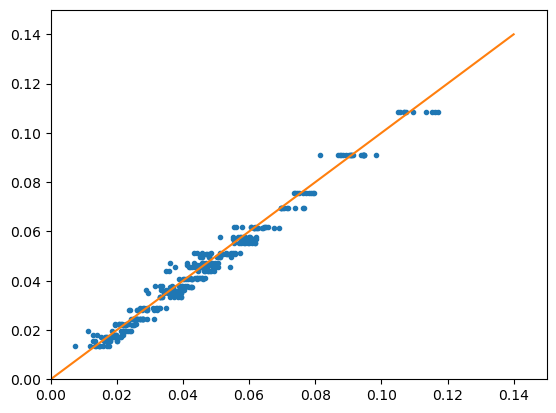

In [4]:
plt.plot(results_array[:,:,:,:,0].flatten(), results_array[:,:,:,:,1].flatten(), '.')
x = np.arange(0, 0.15, 0.01)
plt.plot(x, x)
plt.xlim([0, 0.15])
plt.ylim([0, 0.15])

(-0.007000000000000001,
 0.14700000000000002,
 -0.007000000000000001,
 0.14700000000000002)

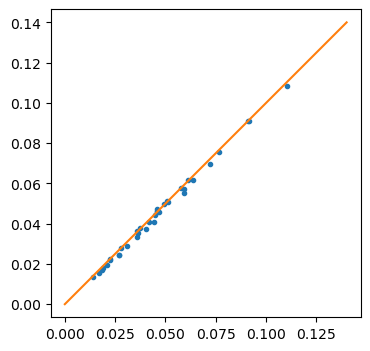

In [7]:
plt.figure(figsize=(4, 4))
plt.plot(results_array[:,:,:,:,0].mean(-1).flatten(), results_array[:,:,:,:,1].mean(-1).flatten(), '.')
x = np.arange(0, 0.15, 0.01)
plt.plot(x, x)
plt.xlim([0, 0.15])
plt.ylim([0, 0.15])
plt.axis('equal')

In [12]:
configs_array

{'g': [3, 8, 20],
 'alpha': [0.5, 0.75, 1, 10],
 'PR_G': [0.5, 0.75, 1],
 'i_seed': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

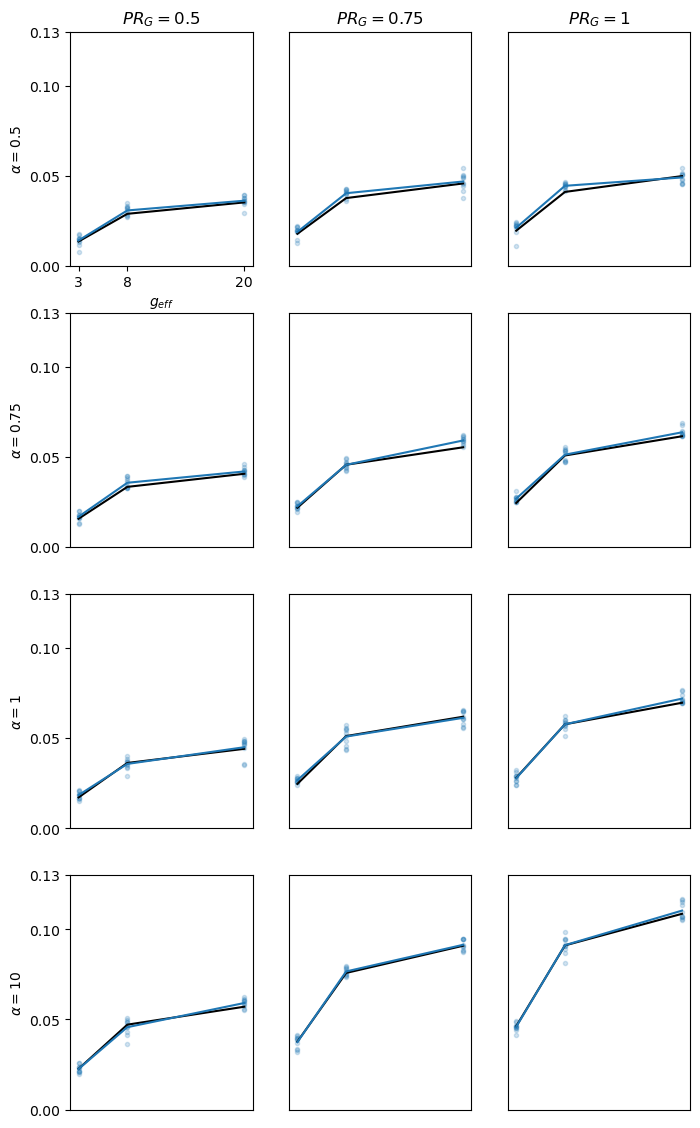

In [28]:
fig, ax = plt.subplots(4, 3, figsize=(8, 14))
for i in range(4):
    for j in range(3):
        ax[i,0].set_ylabel(r'$\alpha = {}$'.format(configs_array['alpha'][i]))
        ax[0,j].set_title(r'$PR_G = {}$'.format(configs_array['PR_G'][j]))
        if i !=0 or j!= 0:
            ax[i,j].set_xticks([])
        if j!=0:
            ax[i,j].set_yticks([])
        else:
            ax[i,j].set_yticks([0, 0.05, 0.1, 0.13])
        for k in range(10):
            ax[i,j].plot(configs_array['g'], results_array[:,i,j,k,0], '.', color='C0', alpha=0.2)
        ax[i,j].plot(configs_array['g'], results_array[:,i,j,0,1], color='k')
        ax[i,j].plot(configs_array['g'], results_array[:,i,j,:,0].mean(-1), color='C0', alpha=1)
        ax[i,j].set_ylim([0, 0.13])
ax[0,0].set_xlabel(r'$g_{eff}$')
ax[0,0].set_xticks(configs_array['g'])
fig.savefig('figs/PR_phi_match.pdf')

In [ ]:
for i_g in range(3):
    fig, ax = plt.subplots(3, 2, figsize=(8, 8))
    lags = results_array[0,0,0,0,0]
    N = 4000
    for i in range(3):
        for j in range(2):
            D = np.ones(int(configs_array['alpha'][i] * N))
            G = np.exp(-configs_array['beta'][j]*np.arange(N)/N)
            PR_G = (np.sum(G**2))**2/np.sum(G**4)/N
            PR_D = (np.sum(D**2))**2/np.sum(D**4)/N
            ax[i,0].set_ylabel('PR D = {}'.format(np.round(PR_D, 2)))
            ax[0,j].set_title('PR G = {}'.format(np.round(PR_G, 2)))
            ax[i,j].plot(lags, results_array[i_g,i,j,:,1,:].mean(0), '.', color='C0')
            for k in range(20):
                ax[i,j].plot(lags, results_array[i_g,i,j,k,1,:], color='C0', alpha=0.2)
            ax[i,j].plot(lags[1:], results_array[i_g,i,j,0,2,1:], color='C1')
    fig.savefig('figs/LDRG_theory_match_lowPR_g={}.pdf'.format(configs_array['g'][i_g]))

In [ ]:
for i_g in [0]:
    fig, ax = plt.subplots(5, 5, figsize=(8, 8))
    lags = results_array[0,0,0,0,0]
    N = 4000
    for i in range(5):
        for j in range(5):
            D = np.ones(int(configs_array['alpha'][i] * N))
            G = np.exp(-configs_array['beta'][j]*np.arange(N)/N)
            PR_G = (np.sum(G**2))**2/np.sum(G**4)/N
            PR_D = (np.sum(D**2))**2/np.sum(D**4)/N
            ax[i,0].set_ylabel('PR D = {}'.format(np.round(PR_D, 2)))
            ax[0,j].set_title('PR G = {}'.format(np.round(PR_G, 2)))
            ax[i,j].plot(lags, results_array[i_g,i,j,:,1,:].mean(0), '.', color='C0')
            for k in range(5):
                ax[i,j].plot(lags, results_array[i_g,i,j,k,1,:], color='C0', alpha=0.2)
            ax[i,j].plot(lags[1:], results_array_1[2,i,j,0,1,1:], color='C1')
    #fig.savefig('figs/LDRG_theory_match_g={}.pdf'.format(configs_array['g'][i_g]))

In [ ]:
for i_g in range(5):
    fig, ax = plt.subplots(5, 5, figsize=(8, 8))
    lags = results_array[0,0,0,0,0]
    N = 4000
    for i in range(5):
        for j in range(5):
            D = np.ones(int(configs_array['alpha'][i] * N))
            G = np.exp(-configs_array['beta'][j]*np.arange(N)/N)
            PR_G = (np.sum(G**2))**2/np.sum(G**4)/N
            PR_D = (np.sum(D**2))**2/np.sum(D**4)/N
            ax[i,0].set_ylabel('PR D = {}'.format(np.round(PR_D, 2)))
            ax[0,j].set_title('PR G = {}'.format(np.round(PR_G, 2)))
            ax[i,j].plot(lags, results_array[i_g,i,j,:,1,:].mean(0), '.', color='C0')
            for k in range(5):
                ax[i,j].plot(lags, results_array[i_g,i,j,k,1,:], color='C0', alpha=0.2)
            ax[i,j].plot(lags, results_array[i_g,i,j,0,2,:], color='C1')
    #fig.savefig('figs/LDRG_theory_match_g={}.pdf'.format(configs_array['g'][i_g]))

In [ ]:
fig, ax = plt.subplots(6, 1, figsize=(4, 12))
T_window = 100
dT = 0.05
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
lags = np.arange(0, T_window, dT)
n_lags = int(T_window/dT)
lags_full = np.concatenate([-lags[-n_lags:][::-1], lags[1:n_lags], np.array([lags[-1]])])
for i in range(6):
    
    #Choose g
    g = configs_array['g'][i]
    
    ### --- Compute single-unit properties
    d = compute_Delta_0(g=g)
    time, Delta_T = integrate_potential(d, g=g, tau_max=T_window, N_tau=int(T_window/dT))
    Delta_T = fix(Delta_T)
    C_Phi_half = compute_C_simple(d, Delta_T)
    alpha = compute_phi_prime_avg(d)
    
    ### --- Compute Psi from theory --- ###

    #Define relevant single-unit functions
    C_phi = np.concatenate([C_Phi_half[-n_lags:][::-1],
                            C_Phi_half[1:n_lags],
                            np.array([C_Phi_half[-1]])])
    C_phi_omega = fft(C_phi, dT)
    T = len(C_phi)
    t_indices= np.concatenate([np.arange(0, T//2), np.arange(-T//2, 0)])
    sampfreq = 1/dT
    w = 2*np.pi*sampfreq*t_indices/T
    C_phi_C_phi = np.multiply.outer(C_phi_omega, C_phi_omega)
    S_phi = alpha/(np.sqrt(2*np.pi)*(1 + 1j*w))
    S_phi_S_phi = np.multiply.outer(S_phi, S_phi)

    #Compute psi for iid random network
    Psi_PRX = (1/(np.abs(1 - 2*np.pi*(g**2) * (S_phi_S_phi))**2) - 1)*C_phi_C_phi
    Psi_PRX_tau = ifft(Psi_PRX, dT)
    Psi_tau_tau = np.diag(Psi_PRX_tau)
    
    ### --- Double check with David's code --- ###
    Psi_tau_2 = compute_psi_theory(symmetrize(Delta_T), g, dT)
    Ptt2 = np.diag(Psi_tau_2)
    Psi_tau_tau_2 = np.concatenate([Ptt2[-len(Ptt2)//2:], Ptt2[:len(Ptt2)//2]])

    for j in range(5):
        ax[i].plot(results_array[i,j,0,:],
                   results_array[i,j,1,:], color='C0', alpha=0.1)
    
    ax[i].plot(results_array[i,j,0,:],
               results_array[i,:,1,:].mean(0), color='C0', alpha=1)
    ax[i].plot(lags_full, Psi_tau_tau, color='C1')
    ax[i].plot(lags_full, Psi_tau_tau_2, color='C2')
    ax[i].set_ylim([0, 14])